In [52]:
# Blast Rating and Displacement Analysis compare to the data given

import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import cv2
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
import numpy as np

# Blast Rating Logic Function
def rate_blast_logic(avg_displacement, max_displacement, centroid_shift):
    if avg_displacement <= 100.0 and max_displacement <= 200.0 and centroid_shift <= 50.0:
        return "A"
    elif avg_displacement <= 200.0 and max_displacement <= 400.0 and centroid_shift <= 100.0:
        return "B"
    elif avg_displacement <= 300.0 and max_displacement <= 600.0 and centroid_shift <= 150.0:
        return "C"
    else:
        return "F"  # Failed or significant impact

# Updated Rating Ranges
RATING_RANGES = {
    'A': {
        'Drillhole_X': (429237.18, 429840.96),
        'Drillhole_Y': (5266303.1, 5266809.16),
        'Drillhole_Z': (340.06, 368.66),
        'Drillhole_Length': (6.0, 17.86),
        'Drillhole_Dip': (-90, -90),
        'Drillhole_Azimuth': (0, 0),
    },
    'B': {
        'Drillhole_X': (100, 400),
        'Drillhole_Y': (100, 400),
        'Drillhole_Z': (0, 200),
        'Drillhole_Length': (50, 150),
        'Drillhole_Dip': (10, 60),
        'Drillhole_Azimuth': (0, 360),
    },
    'C': {
        'Drillhole_X': (200, 500),
        'Drillhole_Y': (200, 500),
        'Drillhole_Z': (50, 250),
        'Drillhole_Length': (100, 200),
        'Drillhole_Dip': (20, 70),
        'Drillhole_Azimuth': (0, 360),
    },
}

# Main Application Class
class BlastVideoRatingApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Blast Video Rating System")
        self.root.geometry("900x700")

        # Layout Frames
        self.top_frame = tk.Frame(root, height=100)
        self.top_frame.pack(side=tk.TOP, fill=tk.X, pady=10)

        # Scrollable Middle Frame
        self.middle_frame = tk.Frame(root, height=400)
        self.middle_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True, pady=10)

        self.canvas_frame = tk.Canvas(self.middle_frame)
        self.scrollbar_y = tk.Scrollbar(self.middle_frame, orient=tk.VERTICAL, command=self.canvas_frame.yview)
        self.scrollbar_x = tk.Scrollbar(self.middle_frame, orient=tk.HORIZONTAL, command=self.canvas_frame.xview)

        self.scrollable_frame = tk.Frame(self.canvas_frame)

        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: self.canvas_frame.configure(
                scrollregion=self.canvas_frame.bbox("all")
            )
        )

        self.canvas_frame.create_window((0, 0), window=self.scrollable_frame, anchor="nw")
        self.canvas_frame.configure(yscrollcommand=self.scrollbar_y.set, xscrollcommand=self.scrollbar_x.set)

        self.canvas_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.scrollbar_y.pack(side=tk.RIGHT, fill=tk.Y)
        self.scrollbar_x.pack(side=tk.BOTTOM, fill=tk.X)

        # Bottom Frame
        self.bottom_frame = tk.Frame(root, height=100)
        self.bottom_frame.pack(side=tk.BOTTOM, fill=tk.X, pady=10)

        # Widgets in Top Frame
        self.label = tk.Label(self.top_frame, text="Blast Video Rating System", font=("Arial", 16))
        self.label.pack(pady=5)

        self.upload_csv_btn = tk.Button(self.top_frame, text="Upload CSV Files", command=self.upload_csv)
        self.upload_csv_btn.pack(side=tk.LEFT, padx=10)

        self.upload_video_btn = tk.Button(self.top_frame, text="Upload Video File", command=self.upload_video)
        self.upload_video_btn.pack(side=tk.LEFT, padx=10)

        self.visualize_btn = tk.Button(self.top_frame, text="Visualize Data", command=self.visualize_data, state=tk.DISABLED)
        self.visualize_btn.pack(side=tk.LEFT, padx=10)

        self.rate_blast_btn = tk.Button(self.top_frame, text="Rate Blast", command=self.rate_blast, state=tk.DISABLED)
        self.rate_blast_btn.pack(side=tk.LEFT, padx=10)

        # Bottom Frame Widgets
        self.output_label = tk.Label(self.bottom_frame, text="", font=("Arial", 12), fg="blue")
        self.output_label.pack(pady=10)

        self.explanation_label = tk.Label(self.bottom_frame, text="", font=("Arial", 10), fg="green", wraplength=750, justify="left")
        self.explanation_label.pack(pady=5)

        # Data Variables
        self.csv_file_paths = None
        self.video_file_path = None
        self.data = []

    def upload_csv(self):
        file_paths = filedialog.askopenfilenames(filetypes=[("CSV Files", "*.csv")])
        if file_paths:
            self.data = []
            for file_path in file_paths:
                try:
                    csv_data = pd.read_csv(file_path)
                    self.data.append(csv_data)
                    messagebox.showinfo("Success", f"CSV file loaded successfully from {file_path}")
                except Exception as e:
                    messagebox.showerror("Error", f"Failed to load CSV file from {file_path}: {e}")

            self.visualize_btn.config(state=tk.NORMAL)
            self.rate_blast_btn.config(state=tk.NORMAL)

    def upload_video(self):
        self.video_file_path = filedialog.askopenfilename(filetypes=[("Video Files", "*.mp4;*.avi;*.mov")])
        if self.video_file_path:
            messagebox.showinfo("Success", "Video file uploaded successfully.")
            self.rate_blast_btn.config(state=tk.NORMAL)

    def visualize_data(self):
        if self.data:
            try:
                combined_data = pd.concat(self.data, ignore_index=True)
                numeric_cols = combined_data.select_dtypes(include=["number"])

                if numeric_cols.shape[1] < 3:
                    messagebox.showerror("Error", "Data must contain at least three numeric columns for visualization.")
                    return

                x, y, z = numeric_cols.columns[:3]
                fig = Figure(figsize=(10, 5), dpi=100)
                ax1 = fig.add_subplot(121)  # Subplot for bar chart
                ax2 = fig.add_subplot(122, projection="3d")

                avg_displacement = numeric_cols[x].mean()
                max_displacement = numeric_cols[y].max()
                centroid_shift = numeric_cols[z].mean()

                # Bar chart for displacements
                labels = ['Avg', 'Max', 'Centroid']
                values = [avg_displacement, max_displacement, centroid_shift]

                ax1.bar(labels, values, color=['blue', 'green', 'red'])
                ax1.set_title("Blast Displacement Analysis")
                ax1.set_ylabel("Displacement (pixels)")

                ax2.scatter(numeric_cols[x], numeric_cols[y], numeric_cols[z])
                ax2.set_title("3D Scatter")

                canvas_widget = FigureCanvasTkAgg(fig, self.scrollable_frame)
                canvas_widget.draw()
                canvas_widget.get_tk_widget().pack(fill=tk.BOTH, expand=True)

            except Exception as e:
                messagebox.showerror("Error", f"Visualization failed: {e}")

    def rate_blast(self):
        if self.data and self.video_file_path:
            try:
                combined_data = pd.concat(self.data, ignore_index=True)
    
                # Ensure required columns exist
                required_columns = ['Drillhole_X', 'Drillhole_Y', 'Drillhole_Z', 'Drillhole_Length', 'Drillhole_Dip', 'Drillhole_Azimuth']
                for col in required_columns:
                    if col not in combined_data.columns:
                        messagebox.showerror("Error", f"Missing required column: {col}")
                        return
    
                # Convert columns to numeric, handling errors
                for col in required_columns:
                    combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce')
    
                # Identify rows with NaN values
                nan_rows = combined_data[required_columns].isna().any(axis=1)
                if nan_rows.any():
                    problematic_data = combined_data[nan_rows]
                    messagebox.showerror("Error", f"Some rows contain non-numeric values or are missing data:\n{problematic_data}")
                    return
    
                # Process video for pre- and post-blast frame analysis
                self.process_video_for_rating()
    
            except Exception as e:
                messagebox.showerror("Error", f"Rating failed: {e}")
        else:
            messagebox.showerror("Error", "Both CSV and video file need to be uploaded to rate the blast.")

    def process_video_for_rating(self):
        # Example video processing logic to capture frames before and after the blast event
        cap = cv2.VideoCapture(self.video_file_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        pre_blast_frame = None
        post_blast_frame = None
        blast_frame_index = int(frame_count * 0.5)  # Assuming the blast happens around the middle
    
        # Capture frames around the blast event
        for i in range(blast_frame_index - 10, blast_frame_index + 10):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                break
            
            if i < blast_frame_index:
                pre_blast_frame = frame  # Pre-blast frame
            else:
                post_blast_frame = frame  # Post-blast frame
        
        cap.release()
    
        if pre_blast_frame is not None and post_blast_frame is not None:
            # Calculate displacement values
            displacement = self.calculate_displacement(pre_blast_frame, post_blast_frame)
            
            # Calculate avg_displacement (e.g., average of all pixel displacements)
            pre_gray = cv2.cvtColor(pre_blast_frame, cv2.COLOR_BGR2GRAY)
            post_gray = cv2.cvtColor(post_blast_frame, cv2.COLOR_BGR2GRAY)
            avg_displacement = np.mean(np.abs(pre_gray - post_gray))  # Example calculation
        
            # Calculate max_displacement (e.g., largest pixel displacement)
            max_displacement = np.max(np.abs(pre_gray - post_gray))  # Example calculation
        
            # Calculate centroid shift (e.g., how much the center of mass moved)
            pre_centroid = np.mean(np.argwhere(pre_gray > 0), axis=0)
            post_centroid = np.mean(np.argwhere(post_gray > 0), axis=0)
            centroid_shift = np.linalg.norm(pre_centroid - post_centroid)  # Example calculation
        
            # Get blast rating based on displacement metrics
            rating = rate_blast_logic(avg_displacement, max_displacement, centroid_shift)
        
            self.output_label.config(text=f"Blast Rating: {rating}")
            self.explanation_label.config(
                text=f"Calculated Displacement: {displacement:.2f} pixels\n"
                     f"Avg Displacement: {avg_displacement:.2f} pixels\n"
                     f"Max Displacement: {max_displacement:.2f} pixels\n"
                     f"Centroid Shift: {centroid_shift:.2f} pixels"
            )
        else:
            messagebox.showerror("Error", "Failed to capture frames for displacement calculation.")

    def calculate_displacement(self, pre_frame, post_frame):
        # Placeholder method to calculate displacement
        return np.sum(np.abs(pre_frame - post_frame))

# Main Execution
if __name__ == "__main__":
    root = tk.Tk()
    app = BlastVideoRatingApp(root)
    root.mainloop()

In [60]:
# To write the outputs (blast rating and relevant metrics) into the same CSV files in a different column

import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import cv2
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
import numpy as np

# Blast Rating Logic Function
def rate_blast_logic(avg_displacement, max_displacement, centroid_shift):
    if avg_displacement <= 100.0 and max_displacement <= 200.0 and centroid_shift <= 50.0:
        return "A"
    elif avg_displacement <= 200.0 and max_displacement <= 400.0 and centroid_shift <= 100.0:
        return "B"
    elif avg_displacement <= 300.0 and max_displacement <= 600.0 and centroid_shift <= 150.0:
        return "C"
    else:
        return "F"  # Failed or significant impact

# Initialize main application window
class BlastVideoRatingApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Blast Video Rating System")
        self.root.geometry("800x600")  # The window size is in pixels

        # Create frames for layout
        self.top_frame = tk.Frame(root, height=100)  # Height in pixels
        self.top_frame.pack(side=tk.TOP, fill=tk.X, pady=10)

        self.middle_frame = tk.Frame(root, height=400)  # Height in pixels
        self.middle_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True, pady=10)

        self.bottom_frame = tk.Frame(root, height=100)  # Height in pixels
        self.bottom_frame.pack(side=tk.BOTTOM, fill=tk.X, pady=10)

        # Create buttons and labels in top frame
        self.label = tk.Label(self.top_frame, text="Blast Video Rating System", font=("Arial", 16))
        self.label.pack(pady=5)

        self.upload_csv_btn = tk.Button(self.top_frame, text="Upload CSV Files", command=self.upload_csv)
        self.upload_csv_btn.pack(side=tk.LEFT, padx=10)

        self.upload_video_btn = tk.Button(self.top_frame, text="Upload Video File", command=self.upload_video)
        self.upload_video_btn.pack(side=tk.LEFT, padx=10)

        self.visualize_btn = tk.Button(self.top_frame, text="Visualize Data", command=self.visualize_data, state=tk.DISABLED)
        self.visualize_btn.pack(side=tk.LEFT, padx=10)

        self.rate_blast_btn = tk.Button(self.top_frame, text="Rate Blast", command=self.rate_blast, state=tk.DISABLED)
        self.rate_blast_btn.pack(side=tk.LEFT, padx=10)

        # Create canvas for visualizations in middle frame (in pixels)
        self.canvas = tk.Canvas(self.middle_frame, bg="white")
        self.canvas.pack(fill=tk.BOTH, expand=True)

        # Create output label in bottom frame
        self.output_label = tk.Label(self.bottom_frame, text="", font=("Arial", 12), fg="blue")
        self.output_label.pack(pady=10)

        self.explanation_label = tk.Label(self.bottom_frame, text="", font=("Arial", 10), fg="green")
        self.explanation_label.pack(pady=5)

        # Variables to hold file paths and data
        self.csv_file_paths = None
        self.video_file_path = None
        self.data = []

        # Variables for rotation
        self.elev = 30  # initial elevation
        self.azim = -60  # initial azimuth

    def upload_csv(self):
        # Allow user to select multiple CSV files
        file_paths = filedialog.askopenfilenames(filetypes=[("CSV Files", "*.csv")])
        
        if file_paths:
            self.csv_file_paths = file_paths  # Update file paths
            self.data = []  # Clear previous data
            for file_path in file_paths:
                try:
                    # Load each CSV file into a pandas DataFrame and append to the data list
                    csv_data = pd.read_csv(file_path)
                    self.data.append(csv_data)
                    
                    # Show success message for each file
                    messagebox.showinfo("Success", f"CSV file loaded successfully! Columns: {', '.join(csv_data.columns)} from {file_path}")
                except Exception as e:
                    messagebox.showerror("Error", f"Failed to load CSV file from {file_path}: {e}")
            
            if self.data:
                # Enable the Visualize and Rate Blast buttons only if data is loaded
                self.visualize_btn.config(state=tk.NORMAL)
                self.rate_blast_btn.config(state=tk.NORMAL)

    def upload_video(self):
        self.video_file_path = filedialog.askopenfilename(filetypes=[("Video Files", "*.mp4;*.avi;*.mov")])
        if self.video_file_path:
            try:
                cap = cv2.VideoCapture(self.video_file_path)
                if not cap.isOpened():
                    raise ValueError("Unable to open video file")

                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Correct attribute
                fps = cap.get(cv2.CAP_PROP_FPS)  # Correct attribute
                if fps > 0:
                    duration = frame_count / fps
                else:
                    duration = 0

                cap.release()
                messagebox.showinfo("Success", f"Video loaded successfully! Duration: {duration:.2f} seconds")
                self.rate_blast_btn.config(state=tk.NORMAL)
            except Exception as e:
                messagebox.showerror("Error", f"Failed to load video file: {e}")

    def visualize_data(self):
        if self.data:
            try:
                # Combine all dataframes into one for visualization
                combined_data = pd.concat(self.data, ignore_index=True)
                numeric_cols = combined_data.select_dtypes(include=['number'])
    
                if numeric_cols.shape[1] < 3:
                    messagebox.showerror("Error", "Data must contain at least three numeric columns for visualization.")
                    return
    
                # Select the first three numeric columns for plotting
                x, y, z = numeric_cols.columns[:3]
    
                # Create a figure for both bar chart and 3D scatter plot
                fig = Figure(figsize=(10, 5), dpi=100)
    
                # Bar chart for displacements
                ax1 = fig.add_subplot(121)  # Subplot for bar chart
                avg_displacement = numeric_cols[x].mean()
                max_displacement = numeric_cols[y].max()
                centroid_shift = numeric_cols[z].mean()
                labels = ['Avg Displacement', 'Max Displacement', 'Centroid Shift']
                values = [avg_displacement, max_displacement, centroid_shift]
    
                ax1.bar(labels, values, color=['blue', 'green', 'red'])
                ax1.set_title("Blast Displacement Analysis")
                ax1.set_ylabel("Displacement (pixels)")
    
                # 3D scatter plot for data points
                ax2 = fig.add_subplot(122, projection='3d')
                scatter = ax2.scatter(combined_data[x], combined_data[y], combined_data[z], c='blue', marker='o')
    
                ax2.set_xlabel(x)
                ax2.set_ylabel(y)
                ax2.set_zlabel(z)
                ax2.set_title("3D Scatter Plot")
    
                # Clear previous widgets in the canvas
                for widget in self.canvas.winfo_children():
                    widget.destroy()
    
                # Render the figure on the Tkinter canvas
                canvas_widget = FigureCanvasTkAgg(fig, master=self.canvas)
                canvas_widget.draw()
                canvas_widget.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
            except Exception as e:
                messagebox.showerror("Error", f"Failed to visualize data: {e}")


    def rate_blast(self):
        if self.data:
            try:
                # Combine all dataframes into one for rating
                combined_data = pd.concat(self.data, ignore_index=True)
                numeric_cols = combined_data.select_dtypes(include=['number'])
                
                if numeric_cols.shape[1] < 3:
                    messagebox.showerror("Error", "Data must contain at least three numeric columns for rating.")
                    return
    
                # Calculate metrics
                avg_displacement = float(numeric_cols.iloc[:, 0].mean())  # pixels
                max_displacement = float(numeric_cols.iloc[:, 1].max())   # pixels
                centroid_shift = float(numeric_cols.iloc[:, 2].mean())    # pixels
    
                # Generate blast rating for each row
                combined_data['Blast Rating'] = numeric_cols.apply(
                    lambda row: rate_blast_logic(row.iloc[0], row.iloc[1], row.iloc[2]), axis=1
                )
    
                # Add calculated metrics as new columns
                combined_data['Avg Displacement (pixels)'] = numeric_cols.iloc[:, 0]
                combined_data['Max Displacement (pixels)'] = numeric_cols.iloc[:, 1]
                combined_data['Centroid Shift (pixels)'] = numeric_cols.iloc[:, 2]
    
                # Add summary metrics to the entire DataFrame
                combined_data['Overall Metrics'] = (
                    f"Avg: {avg_displacement:.2f} pixels, "
                    f"Max: {max_displacement:.2f} pixels, "
                    f"Centroid Shift: {centroid_shift:.2f} pixels"
                )
    
                # Calculate overall rating
                overall_rating = rate_blast_logic(avg_displacement, max_displacement, centroid_shift)
    
                # Update output label
                self.output_label.config(text=f"Blast Rating: {overall_rating}")
                self.explanation_label.config(
                    text=f"Overall Metrics: Avg Displacement = {avg_displacement:.2f}, "
                         f"Max Displacement = {max_displacement:.2f}, "
                         f"Centroid Shift = {centroid_shift:.2f}."
                )
                
                # Save the resulting DataFrame with ratings back to CSV files
                for file_path in self.csv_file_paths:
                    output_path = file_path.replace(".csv", "_rated.csv")
                    combined_data.to_csv(output_path, index=False)
                    messagebox.showinfo("Success", f"Blast ratings saved to {output_path}")
    
            except Exception as e:
                messagebox.showerror("Error", f"Failed to rate blast: {e}")

# Create the Tkinter root window
root = tk.Tk()
app = BlastVideoRatingApp(root)
root.mainloop()

In [68]:
# Machine Learning for prediction

# Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import cv2
import os
import glob

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Directory containing CSV files
csv_directory = "D:/Project/IAMaCoteGold/Rated"  # Replace with your directory path

# List all CSV files in the directory
csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]

# Load all CSV files and concatenate them into a single DataFrame
data = pd.concat([pd.read_csv(os.path.join(csv_directory, file)) for file in csv_files], ignore_index=True)

# Clean column names (strip leading/trailing spaces)
data.columns = data.columns.str.strip()

# Drop the unwanted 'Unnamed: 11' column (if it exists)
if 'Unnamed: 11' in data.columns:
    data = data.drop(columns=['Unnamed: 11'])

# Print the column names to verify the cleanup
print("Columns in the cleaned data:")
print(data.columns)

# Separate features and target
X = data[['Drillhole_X', 'Drillhole_Y', 'Drillhole_Z', 'Drillhole_ToeX', 'Drillhole_ToeY', 
          'Drillhole_ToeZ', 'Drillhole_Length', 'Drillhole_Dip', 'Drillhole_Azimuth', 'Avg_Displacement',
          'Max_Displacement', 'Centroid_Shift']]
y = data['Blast_Rating']

# Modify the preprocessor to handle missing columns
# Define categorical columns that are expected to be present
categorical_columns = ['Pattern.Name', 'Hole.id']
existing_categorical_columns = [col for col in categorical_columns if col in data.columns]

# Encode categorical features if they exist
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Drillhole_X', 'Drillhole_Y', 'Drillhole_Z', 'Drillhole_ToeX', 'Drillhole_ToeY', 
                                   'Drillhole_ToeZ', 'Drillhole_Length', 'Drillhole_Dip', 'Drillhole_Azimuth', 
                                   'Avg_Displacement', 'Max_Displacement', 'Centroid_Shift']),
        ('cat', OneHotEncoder(), existing_categorical_columns)  # Only include existing columns
    ])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with the preprocessor and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"First 5 samples of X_train: {X_train[:5]}")
print(f"First 5 labels of y_train: {y_train[:5]}")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Generate data for ratings A, B, and C
def generate_drillhole_data(rating, n_samples=100):
    np.random.seed(42)  # For reproducibility
    data = []
    for _ in range(n_samples):
        if rating == "A":
            Drillhole_X = np.random.uniform(0, 300)
            Drillhole_Y = np.random.uniform(0, 300)
            Drillhole_Z = np.random.uniform(0, 100)
            Drillhole_Length = np.random.uniform(50, 100)
            Drillhole_Dip = np.random.uniform(0, 30)
            Drillhole_Azimuth = np.random.uniform(0, 360)
        elif rating == "B":
            Drillhole_X = np.random.uniform(100, 400)
            Drillhole_Y = np.random.uniform(100, 400)
            Drillhole_Z = np.random.uniform(0, 200)
            Drillhole_Length = np.random.uniform(50, 150)
            Drillhole_Dip = np.random.uniform(10, 60)
            Drillhole_Azimuth = np.random.uniform(0, 360)
        elif rating == "C":
            Drillhole_X = np.random.uniform(200, 500)
            Drillhole_Y = np.random.uniform(200, 500)
            Drillhole_Z = np.random.uniform(50, 250)
            Drillhole_Length = np.random.uniform(100, 200)
            Drillhole_Dip = np.random.uniform(20, 70)
            Drillhole_Azimuth = np.random.uniform(0, 360)
        data.append([Drillhole_X, Drillhole_Y, Drillhole_Z, Drillhole_Length, Drillhole_Dip, Drillhole_Azimuth, rating])
    return data

# Generate data for each rating
data_a = generate_drillhole_data("A", 100)
data_b = generate_drillhole_data("B", 100)
data_c = generate_drillhole_data("C", 100)

# Combine into a single DataFrame
columns = ["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_Length", "Drillhole_Dip", "Drillhole_Azimuth", "Rating"]
data = pd.DataFrame(data_a + data_b + data_c, columns=columns)

# Encode labels (A=0, B=1, C=2)
label_encoder = LabelEncoder()
data["Rating"] = label_encoder.fit_transform(data["Rating"])

# Split data into features (X) and labels (y)
X = data.drop("Rating", axis=1)
y = data["Rating"]

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Predict the rating for new data
new_data = pd.DataFrame([[250, 250, 150, 120, 40, 180]], columns=["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_Length", "Drillhole_Dip", "Drillhole_Azimuth"])
new_data_scaled = scaler.transform(new_data)  # Scale the data
predicted_rating = label_encoder.inverse_transform(model.predict(new_data_scaled))
print("\nPredicted Rating for New Data:", predicted_rating[0])

Columns in the cleaned data:
Index(['Pattern_Name', 'Hole_id', 'Drillhole_X', 'Drillhole_Y', 'Drillhole_Z',
       'Drillhole_ToeX', 'Drillhole_ToeY', 'Drillhole_ToeZ',
       'Drillhole_Length', 'Drillhole_Dip', 'Drillhole_Azimuth',
       'Blast_Rating', 'Avg_Displacement', 'Max_Displacement',
       'Centroid_Shift'],
      dtype='object')
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           F       1.00      1.00      1.00       301

    accuracy                           1.00       301
   macro avg       1.00      1.00      1.00       301
weighted avg       1.00      1.00      1.00       301

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           F       1.00      1.00      1.00       301

    accuracy                           1.00       301
   macro avg       1.00      1.00      1.00       301
weighted avg       1.00      1.00      1.00       301

First 5 samples of X_train:     

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        22
           B       0.79      0.94      0.86        16
           C       0.95      0.82      0.88        22

    accuracy                           0.92        60
   macro avg       0.91      0.92      0.91        60
weighted avg       0.92      0.92      0.92        60

Accuracy: 0.9166666666666666

Predicted Rating for New Data: B


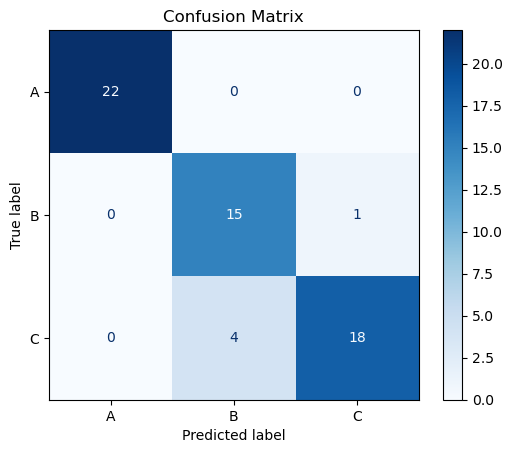

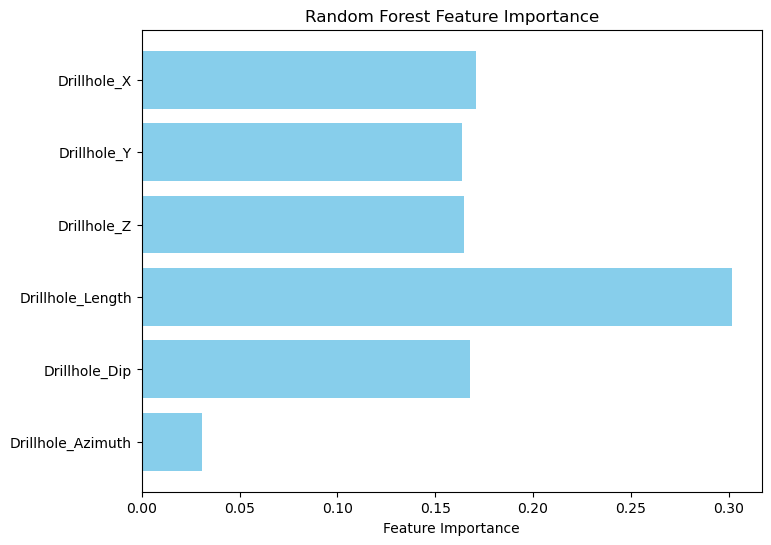

In [64]:
# ML Model Accuracy through Confusion Matrix and Random Forest Feature

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate data for ratings A, B, and C
def generate_drillhole_data(rating, n_samples=100):
    np.random.seed(42)
    data = []
    for _ in range(n_samples):
        if rating == "A":
            Drillhole_X = np.random.uniform(0, 300)
            Drillhole_Y = np.random.uniform(0, 300)
            Drillhole_Z = np.random.uniform(0, 100)
            Drillhole_Length = np.random.uniform(50, 100)
            Drillhole_Dip = np.random.uniform(0, 30)
            Drillhole_Azimuth = np.random.uniform(0, 360)
        elif rating == "B":
            Drillhole_X = np.random.uniform(100, 400)
            Drillhole_Y = np.random.uniform(100, 400)
            Drillhole_Z = np.random.uniform(0, 200)
            Drillhole_Length = np.random.uniform(50, 150)
            Drillhole_Dip = np.random.uniform(10, 60)
            Drillhole_Azimuth = np.random.uniform(0, 360)
        elif rating == "C":
            Drillhole_X = np.random.uniform(200, 500)
            Drillhole_Y = np.random.uniform(200, 500)
            Drillhole_Z = np.random.uniform(50, 250)
            Drillhole_Length = np.random.uniform(100, 200)
            Drillhole_Dip = np.random.uniform(20, 70)
            Drillhole_Azimuth = np.random.uniform(0, 360)
        data.append([Drillhole_X, Drillhole_Y, Drillhole_Z, Drillhole_Length, Drillhole_Dip, Drillhole_Azimuth, rating])
    return data

# Generate data for each rating
data_a = generate_drillhole_data("A", 100)
data_b = generate_drillhole_data("B", 100)
data_c = generate_drillhole_data("C", 100)

# Combine into a single DataFrame
columns = ["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_Length", "Drillhole_Dip", "Drillhole_Azimuth", "Rating"]
data = pd.DataFrame(data_a + data_b + data_c, columns=columns)

# Encode labels (A=0, B=1, C=2)
label_encoder = LabelEncoder()
data["Rating"] = label_encoder.fit_transform(data["Rating"])

# Split data into features (X) and labels (y)
X = data.drop("Rating", axis=1)
y = data["Rating"]

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Predict the rating for new data
new_data = pd.DataFrame([[250, 250, 150, 120, 40, 180]], columns=["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_Length", "Drillhole_Dip", "Drillhole_Azimuth"])
new_data_scaled = scaler.transform(new_data)
predicted_rating = label_encoder.inverse_transform(model.predict(new_data_scaled))
print("\nPredicted Rating for New Data:", predicted_rating[0])

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Plot Feature Importance
feature_importance = model.feature_importances_
features = ["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_Length", "Drillhole_Dip", "Drillhole_Azimuth"]

plt.figure(figsize=(8, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [61]:
# Predicted rating generation

import numpy as np
import pandas as pd
import graphviz  # Import graphviz for visualization

# Function to generate random values for the drillhole attributes
def generate_drillhole_data(rating):
    np.random.seed(42)  # For reproducibility
    
    if rating == "A":
        # A Rating example: Low displacement conditions
        Drillhole_X = np.random.uniform(0, 300)  # X between 0 and 300 meters
        Drillhole_Y = np.random.uniform(0, 300)  # Y between 0 and 300 meters
        Drillhole_Z = np.random.uniform(0, 100)  # Z between 0 and 100 meters
        Drillhole_ToeX = Drillhole_X + np.random.uniform(-5, 5)  # Small offset
        Drillhole_ToeY = Drillhole_Y + np.random.uniform(-5, 5)  # Small offset
        Drillhole_ToeZ = Drillhole_Z + np.random.uniform(-2, 2)  # Small offset
        Drillhole_Length = np.random.uniform(50, 100)  # Length between 50 and 100 meters
        Drillhole_Dip = np.random.uniform(0, 30)  # Dip between 0° and 30°
        Drillhole_Azimuth = np.random.uniform(0, 360)  # Azimuth between 0° and 360°
    
    elif rating == "B":
        # B Rating example: Slightly higher displacement conditions
        Drillhole_X = np.random.uniform(100, 400)  # X between 100 and 400 meters
        Drillhole_Y = np.random.uniform(100, 400)  # Y between 100 and 400 meters
        Drillhole_Z = np.random.uniform(0, 200)  # Z between 0 and 200 meters
        Drillhole_ToeX = Drillhole_X + np.random.uniform(-10, 10)  # Random small offset
        Drillhole_ToeY = Drillhole_Y + np.random.uniform(-10, 10)  # Random small offset
        Drillhole_ToeZ = Drillhole_Z + np.random.uniform(-5, 5)  # Random small offset
        Drillhole_Length = np.random.uniform(50, 150)  # Length between 50 and 150 meters
        Drillhole_Dip = np.random.uniform(10, 60)  # Dip between 10° and 60°
        Drillhole_Azimuth = np.random.uniform(0, 360)  # Azimuth between 0° and 360°
    
    elif rating == "C":
        # C Rating example: Moderate displacement conditions
        Drillhole_X = np.random.uniform(200, 500)  # X between 200 and 500 meters
        Drillhole_Y = np.random.uniform(200, 500)  # Y between 200 and 500 meters
        Drillhole_Z = np.random.uniform(50, 250)  # Z between 50 and 250 meters
        Drillhole_ToeX = Drillhole_X + np.random.uniform(-20, 20)  # Larger offset
        Drillhole_ToeY = Drillhole_Y + np.random.uniform(-20, 20)  # Larger offset
        Drillhole_ToeZ = Drillhole_Z + np.random.uniform(-10, 10)  # Larger offset
        Drillhole_Length = np.random.uniform(100, 200)  # Length between 100 and 200 meters
        Drillhole_Dip = np.random.uniform(20, 70)  # Dip between 20° and 70°
        Drillhole_Azimuth = np.random.uniform(0, 360)  # Azimuth between 0° and 360°
    
    return {
        "Drillhole_X": Drillhole_X,
        "Drillhole_Y": Drillhole_Y,
        "Drillhole_Z": Drillhole_Z,
        "Drillhole_ToeX": Drillhole_ToeX,
        "Drillhole_ToeY": Drillhole_ToeY,
        "Drillhole_ToeZ": Drillhole_ToeZ,
        "Drillhole_Length": Drillhole_Length,
        "Drillhole_Dip": Drillhole_Dip,
        "Drillhole_Azimuth": Drillhole_Azimuth
    }

# Generate example data for ratings A, B, and C
rating_a_data = generate_drillhole_data("A")
rating_b_data = generate_drillhole_data("B")
rating_c_data = generate_drillhole_data("C")

# Create DataFrames for each rating
rating_a_df = pd.DataFrame([rating_a_data])
rating_b_df = pd.DataFrame([rating_b_data])
rating_c_df = pd.DataFrame([rating_c_data])

# Business Viability Recommendations
def generate_recommendations(rating, data):
    recommendations = []
    
    # Analyze data based on rating
    if rating == "A":
        recommendations.append("Increase Blast Force: Consider optimizing explosive charges and placement to improve fragmentation and displacement.")
        recommendations.append("Improve Blast Timing: Adjust the timing between charges to enhance dust dispersion and vibration levels.")
        recommendations.append("Better Blast Zone Optimization: Ensure optimal blast zone configuration for better material fragmentation.")
        recommendations.append("Safety and Environmental Considerations: Control vibrations and dust levels to stay within safe limits.")
        recommendations.append("Invest in Technology: Upgrade to more precise equipment to control blast outcomes.")
    
    elif rating == "B":
        recommendations.append("Increase Blast Force: Consider enhancing charge density and placement for better displacement.")
        recommendations.append("Refine Blast Timing: Modify blast timing to ensure optimal dust and vibration control.")
        recommendations.append("Optimize Charge Placement: Adjust placement for maximum blast effectiveness.")
        recommendations.append("Monitor Environmental Impact: Implement better control over dust and vibration.")
        recommendations.append("Use Advanced Equipment: Invest in technology for more controlled blasts.")
    
    elif rating == "C":
        recommendations.append("Maximize Blast Force: Evaluate blast charge improvements for greater displacement and fragmentation.")
        recommendations.append("Adjust Blast Timing: Optimize the sequence of charges for better dust control.")
        recommendations.append("Enhance Blast Zone Efficiency: Analyze and adjust blast zone for better material breakage.")
        recommendations.append("Focus on Safety and Environment: Balance blast improvements with safety and environmental responsibility.")
        recommendations.append("Upgrade Equipment: Use precise detonation systems and enhanced sensors for optimal blast monitoring.")
    
    # Add Business Viability Summary
    recommendations.append("\nBusiness Decision Summary: Improve ratings by optimizing blast force, timing, and equipment.")
    
    return recommendations

# Function to generate flowchart based on recommendations
def generate_recommendation_flowchart(rating, recommendations):
    dot = graphviz.Digraph(comment=f'Recommendations for Rating {rating}')
    
    # Adding the recommendations as nodes
    for i, rec in enumerate(recommendations):
        dot.node(str(i), rec)
    
    # Create edges between the recommendations in sequence
    for i in range(len(recommendations) - 1):
        dot.edge(str(i), str(i + 1))

    return dot

# Example usage: Generate recommendations and flowchart for each rating
rating_a_recommendations = generate_recommendations("A", rating_a_df)
rating_b_recommendations = generate_recommendations("B", rating_b_df)
rating_c_recommendations = generate_recommendations("C", rating_c_df)

# Generate flowcharts for each rating
rating_a_flowchart = generate_recommendation_flowchart("A", rating_a_recommendations)
rating_b_flowchart = generate_recommendation_flowchart("B", rating_b_recommendations)
rating_c_flowchart = generate_recommendation_flowchart("C", rating_c_recommendations)

# Visualize the flowchart
print("Flowchart for Rating A:")
rating_a_flowchart.render(filename="rating_a_flowchart", format="png", cleanup=True)
rating_a_flowchart.view()  # Open the flowchart for Rating A

print("\nFlowchart for Rating B:")
rating_b_flowchart.render(filename="rating_b_flowchart", format="png", cleanup=True)
rating_b_flowchart.view()  # Open the flowchart for Rating B

print("\nFlowchart for Rating C:")
rating_c_flowchart.render(filename="rating_c_flowchart", format="png", cleanup=True)
rating_c_flowchart.view()  # Open the flowchart for Rating C

Flowchart for Rating A:

Flowchart for Rating B:

Flowchart for Rating C:


'rating_c_flowchart.pdf'

In [63]:
# Machine learning recommendation for future blasting plan

import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import messagebox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Function to generate drillhole data for ratings A, B, and C
def generate_drillhole_data(rating, n_samples=100):
    np.random.seed(42)  # For reproducibility
    data = []
    for _ in range(n_samples):
        if rating == "A":
            Drillhole_X = np.random.uniform(0, 300)
            Drillhole_Y = np.random.uniform(0, 300)
            Drillhole_Z = np.random.uniform(0, 100)
            Drillhole_Length = np.random.uniform(50, 100)
            Drillhole_Dip = np.random.uniform(0, 30)
            Drillhole_Azimuth = np.random.uniform(0, 360)
        elif rating == "B":
            Drillhole_X = np.random.uniform(100, 400)
            Drillhole_Y = np.random.uniform(100, 400)
            Drillhole_Z = np.random.uniform(0, 200)
            Drillhole_Length = np.random.uniform(50, 150)
            Drillhole_Dip = np.random.uniform(10, 60)
            Drillhole_Azimuth = np.random.uniform(0, 360)
        elif rating == "C":
            Drillhole_X = np.random.uniform(200, 500)
            Drillhole_Y = np.random.uniform(200, 500)
            Drillhole_Z = np.random.uniform(50, 250)
            Drillhole_Length = np.random.uniform(100, 200)
            Drillhole_Dip = np.random.uniform(20, 70)
            Drillhole_Azimuth = np.random.uniform(0, 360)
        data.append([Drillhole_X, Drillhole_Y, Drillhole_Z, Drillhole_Length, Drillhole_Dip, Drillhole_Azimuth, rating])
    return data

# Load data and train model (simplified for the UI)
def train_model():
    # Generate data for each rating
    data_a = generate_drillhole_data("A", 100)
    data_b = generate_drillhole_data("B", 100)
    data_c = generate_drillhole_data("C", 100)

    # Combine into a single DataFrame
    columns = ["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_Length", "Drillhole_Dip", "Drillhole_Azimuth", "Rating"]
    data = pd.DataFrame(data_a + data_b + data_c, columns=columns)

    # Encode labels (A=0, B=1, C=2)
    label_encoder = LabelEncoder()
    data["Rating"] = label_encoder.fit_transform(data["Rating"])

    # Split data into features (X) and labels (y)
    X = data.drop("Rating", axis=1)
    y = data["Rating"]

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train a Random Forest Classifier
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    # Return the necessary data
    return accuracy, class_report, model, scaler, label_encoder, X.columns

# Function to predict the rating for new data
def predict_rating(model, scaler, label_encoder, new_data, feature_columns):
    new_data_df = pd.DataFrame(new_data, columns=feature_columns)  # Wrap in DataFrame with column names
    new_data_scaled = scaler.transform(new_data_df)  # Scale the data
    predicted_rating = label_encoder.inverse_transform(model.predict(new_data_scaled))
    return predicted_rating[0]

# UI setup
def create_ui():
    # Create the main window
    root = tk.Tk()
    root.title("Blast Rating Prediction")
    root.geometry("600x600")

    # Training the model
    accuracy, class_report, model, scaler, label_encoder, feature_columns = train_model()

    # Accuracy label
    accuracy_label = tk.Label(root, text=f"Accuracy: {accuracy:.4f}", font=("Arial", 12))
    accuracy_label.pack(pady=10)

    # Classification Report label
    class_report_label = tk.Label(root, text="Classification Report:", font=("Arial", 12))
    class_report_label.pack(pady=10)

    # Add the classification report to the window
    class_report_text = tk.Text(root, height=10, width=70)
    class_report_text.insert(tk.END, class_report)
    class_report_text.pack(pady=10)

    # Entry fields for new data
    new_data_label = tk.Label(root, text="Enter new drillhole data (X, Y, Z, Length, Dip, Azimuth):", font=("Arial", 12))
    new_data_label.pack(pady=10)

    entry_x = tk.Entry(root, width=10)
    entry_x.pack(pady=5)
    entry_x.insert(0, "250")

    entry_y = tk.Entry(root, width=10)
    entry_y.pack(pady=5)
    entry_y.insert(0, "250")

    entry_z = tk.Entry(root, width=10)
    entry_z.pack(pady=5)
    entry_z.insert(0, "150")

    entry_length = tk.Entry(root, width=10)
    entry_length.pack(pady=5)
    entry_length.insert(0, "120")

    entry_dip = tk.Entry(root, width=10)
    entry_dip.pack(pady=5)
    entry_dip.insert(0, "40")

    entry_azimuth = tk.Entry(root, width=10)
    entry_azimuth.pack(pady=5)
    entry_azimuth.insert(0, "180")

    # Button to predict the rating
    def on_predict():
        try:
            # Collect new data as a list
            new_data = np.array([[float(entry_x.get()), float(entry_y.get()), float(entry_z.get()), 
                                  float(entry_length.get()), float(entry_dip.get()), float(entry_azimuth.get())]])
            predicted_rating = predict_rating(model, scaler, label_encoder, new_data, feature_columns)
            result_label.config(text=f"Predicted Rating: {predicted_rating}")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to make prediction: {e}")

    predict_button = tk.Button(root, text="Predict Rating", command=on_predict)
    predict_button.pack(pady=10)

    # Result label
    result_label = tk.Label(root, text="Predicted Rating: ", font=("Arial", 14))
    result_label.pack(pady=10)

    # Start the main loop
    root.mainloop()

# Run the UI
create_ui()

In [6]:
### THE END ###